In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib_inline.backend_inline
from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.io import fits
from pathlib import Path
import numpy as np
import eazy
import pickle
import gc
import os
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 25

WD = Path('/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge')
os.chdir(WD)
TEMPDIR = WD.parent / 'BROWN_COSMOS'

from utils import get_result_figures

In [3]:
survey = 'IMS'
template = 'reddened'
zstep = '001'
catalog = '_sub'
extcorr = '_extcorrcat'

scheme = f'{template}_{zstep}_{survey}{catalog}{extcorr}'
print('Scheme:', scheme)

Scheme: reddened_001_IMS_sub_extcorrcat


In [58]:
def get_basecat_scheme(survey, template, zstep, catalog, extcorr, read_base=False):
    scheme = f'{template}_{zstep}_{survey}{catalog}{extcorr}'
    outdir = WD / 'output' / f'output_{scheme}'
    incatname = f'input_{survey}_subset.csv' if catalog == '_sub' else f'input_{survey}.csv'
    incatpath = WD / 'input' / incatname
    figdir = outdir / 'figures'

    figdir.mkdir(exist_ok=True, parents=True)

    if read_base:
        base = Table.read(outdir / 'result.fits')
    else:
        base = Table.read(incatpath)
        colnames = ['z_phot', 'z_phot_chi2', 'z160', 'z840', 'id']
        for label in colnames:
            base[label] = np.empty(len(base), dtype=float)

        if catalog == '_sub':
            outtab = Table.read(outdir / 'output.fits')
            for label in colnames:
                base[label] = outtab[label]
        else:
            for i in range(17):
                start_id = i*10000
                end_id = (i+1)*10000 if i < 16 else len(base)
                
                outtab = Table.read(outdir/f'output{i:02d}.fits')
                for label in colnames:
                    base[label][start_id:end_id] = outtab[label]
    
        base.write(outdir / 'result.fits', overwrite=True)
        
    return scheme, base, figdir

scheme, base, figdir = get_basecat_scheme(survey, template, zstep, catalog, extcorr)            

In [5]:
base

ID,HSC_i_MAG,z_spec,FLAG_ML,ra,dec,E_B-V_,Classic,EZzphot,F419,F420,F421,F422,F423,F424,F425,F426,F427,F428,F429,F430,F431,F432,F433,F434,F435,F436,F437,F438,E419,E420,E421,E422,E423,E424,E425,E426,E427,E428,E429,E430,E431,E432,E433,E434,E435,E436,E437,E438,z_phot,z_phot_chi2,z160,z840,id
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,int64
738963,21.103617245014533,0.6216,0.0,150.37386852,2.5073432,0.017709000000000003,1149026,0.621499,2.6112547335475473,2.880827015647063,3.160543670939539,3.463803940982909,4.053598783827961,4.083686711306581,4.584210172368202,4.840942794035633,5.5103009678999815,7.041498401813331,8.252698095892232,9.369820125607335,9.905548836387496,11.198232063729364,12.000284219987202,11.928226634204313,14.883394175130066,14.092583818552985,14.444636249893238,16.073252786167917,0.13081352218667033,0.11817044949772083,0.11332117545091479,0.11422429288378155,0.11150009635951957,0.11870593904875958,0.1407258408619308,0.14070954157364457,0.1572242157892294,0.19155481187477152,0.189613925199004,0.20481156422405614,0.23172283068430174,0.30362998470967656,0.34035953083562187,0.4759623497362729,0.5301821000838206,0.5884940597372528,0.7420255058992078,1.0206752601973432,0.6291627,77.15479,0.6249,0.6566,738963
715464,24.377794723854887,2.8899,0.0,149.88668403,2.68432357,0.016769000000000003,1329160,2.897937,0.12151598926336958,0.3584347201955358,0.34733388829890327,0.5020661762557931,0.6328735585973589,0.5624087072335401,0.6242182920296966,0.6317265235773546,0.8703685142797455,0.6735055083475647,0.6820923757788929,0.6711097666622994,0.36135658886955546,0.7425879604192497,0.8094518172128994,0.080562110864082,1.0814976051164957,1.6565899729294236,0.4182443407641414,1.6563452546260182,0.1276735282700148,0.11386503800816561,0.10837556915229639,0.10821105381240785,0.10450832704019142,0.11137588868342073,0.13277876519430787,0.1319900871500606,0.14623050375575822,0.1780484914337715,0.16865507251109776,0.1791035677640766,0.20713651332271157,0.2796597971890184,0.3133472094030086,0.4544160323777001,0.5044138041437072,0.5660274983395606,0.7234725201698244,1.0043693898512953,2.791267,12.428036,0.2410,2.8741,715464
473138,24.860202039062116,0.9685,0.0,149.54777689,2.33306889,0.016961,963893,0.9487250000000002,0.04423105432110469,0.33244200770326515,0.19329279502659547,0.20700307966416848,0.33608156887004303,0.30427946112542836,0.4068177920792251,0.1730945521430573,0.3977236077172632,0.3610899384540743,0.18305546154165617,0.1214510551182146,0.32351521150066637,0.1134531475527269,0.4973176838466331,0.2944468259407356,0.7842863899305526,0.4253702374539035,1.3856680526005134,1.3285771976018221,0.12765764995177517,0.11381966964749346,0.10832531726999046,0.10811593976964756,0.10430687656325704,0.11116029353998198,0.1326074029694002,0.13177898328086543,0.14606151005445417,0.1778726131122731,0.16844405687958985,0.17889481282303707,0.20693622364411804,0.27955189350268445,0.3132328511825196,0.4543446087074313,0.5043764122691464,0.5659871649119609,0.7234518136522375,1.0043454126989328,3.2360702,8.038663,1.1693,3.1155,473138
413948,24.15871535721088,1.1851,0.0,149.61846183,1.75661489,0.017031,351738,1.171315,0.5501395346609569,0.6435289580567682,0.21845962725494047,0.36416562545202913,0.43631866454198637,0.32571096825483636,0.36727090636224763,0.700686729167902,0.7917810486927402,0.774690774706932,0.7296322530816454,0.6048745647892082,0.6610764034268706,0.7169923704213013,0.586646294988686,0.7452351801356245,0.4760404402437604,0.7421513595286009,0.37055251028952035,1.7200481265424403,0.12782117246321245,0.11396098320468745,0.10844739342794252,0.10823197921468611,0.1044345602

In [7]:
catalog = "_sub"
zstep = "001"
for surv in ["IMS", "WFS", "RIS"]:
    for temp in ["nored", "reddened"]:
        for extc in ["", "_extcorrcat"]:
            scheme, base, figdir = get_basecat_scheme(
                survey=surv,
                template=temp,
                zstep=zstep,
                catalog=catalog,
                extcorr=extc,
            )
            base.rename_column('z_spec', 'z_true')
            get_result_figures(base, figdir, scheme)

Objects : 9786
Outliers: 6037




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 6


Objects : 21
Outliers: 6




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 12




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 12




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 22




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 22




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 520
Outliers: 59




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 520
Outliers: 59




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1269
Outliers: 407




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1269
Outliers: 407




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7678
Outliers: 5531




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7678
Outliers: 5531




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 1680
Outliers: 259




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 1680
Outliers: 259




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 926
Outliers: 121




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 926
Outliers: 121




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 9794
Outliers: 6051




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 6


Objects : 21
Outliers: 6




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 12




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 12




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 22




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 22




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 520
Outliers: 61




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 520
Outliers: 61




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1269
Outliers: 406




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1269
Outliers: 406




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7686
Outliers: 5544




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7686
Outliers: 5544




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 1688
Outliers: 263




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 1688
Outliers: 263




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 938
Outliers: 122




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 938
Outliers: 122




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 9776
Outliers: 6091




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 9


Objects : 21
Outliers: 9




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 30




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 30




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 520
Outliers: 72




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 520
Outliers: 72




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1266
Outliers: 416




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1266
Outliers: 416




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7671
Outliers: 5548




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7671
Outliers: 5548




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 1693
Outliers: 314




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 1693
Outliers: 314




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 910
Outliers: 150




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 910
Outliers: 150




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 9779
Outliers: 6093




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 9


Objects : 21
Outliers: 9




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 29




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 29




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 520
Outliers: 72




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 520
Outliers: 72




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1266
Outliers: 416




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1266
Outliers: 416




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7674
Outliers: 5551




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7674
Outliers: 5551




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 1699
Outliers: 315




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 1699
Outliers: 315




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 921
Outliers: 148




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 921
Outliers: 148




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 9580
Outliers: 7462




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 6


Objects : 21
Outliers: 6




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 208
Outliers: 33




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 208
Outliers: 33




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 513
Outliers: 166




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 513
Outliers: 166




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1245
Outliers: 779




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1245
Outliers: 779




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7504
Outliers: 6462




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7504
Outliers: 6462




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 458
Outliers: 91




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 458
Outliers: 91




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 249
Outliers: 51




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 249
Outliers: 51




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 9586
Outliers: 7480




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 7


Objects : 21
Outliers: 7




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 208
Outliers: 33




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 208
Outliers: 33




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 514
Outliers: 166




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 514
Outliers: 166




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1246
Outliers: 786




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1246
Outliers: 786




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7508
Outliers: 6472




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7508
Outliers: 6472




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 461
Outliers: 90




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 461
Outliers: 90




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 251
Outliers: 50




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 251
Outliers: 50




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 9578
Outliers: 7454




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 7


Objects : 21
Outliers: 7




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 208
Outliers: 42




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 208
Outliers: 42




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 513
Outliers: 176




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 513
Outliers: 176




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1243
Outliers: 794




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1243
Outliers: 794




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7504
Outliers: 6419




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7504
Outliers: 6419




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 478
Outliers: 128




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 478
Outliers: 128




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 244
Outliers: 59




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 244
Outliers: 59




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 9580
Outliers: 7460




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 7


Objects : 21
Outliers: 7




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 16




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 207
Outliers: 40




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 207
Outliers: 40




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 513
Outliers: 176




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 513
Outliers: 176




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1243
Outliers: 794




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1243
Outliers: 794




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7507
Outliers: 6427




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7507
Outliers: 6427




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 488
Outliers: 133




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 488
Outliers: 133




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 243
Outliers: 58




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 243
Outliers: 58




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 8819
Outliers: 7862




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 8




/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 21
Outliers: 8




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 89
Outliers: 45




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 45




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 206
Outliers: 137




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 206
Outliers: 137




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 494
Outliers: 379




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 494
Outliers: 379




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1157
Outliers: 973




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1157
Outliers: 973




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 6852
Outliers: 6320




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 6852
Outliers: 6320




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 20
Outliers: 15




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 20
Outliers: 15




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 7
Outliers: 4




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 7
Outliers: 4




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 8817
Outliers: 7866




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 9




/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 21
Outliers: 9




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 89
Outliers: 44




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 44




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 206
Outliers: 136




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 206
Outliers: 136




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 494
Outliers: 381




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 494
Outliers: 381




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1158
Outliers: 974




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1158
Outliers: 974




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 6849
Outliers: 6322




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 6849
Outliers: 6322




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 20
Outliers: 15




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 20
Outliers: 15




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 7
Outliers: 4




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 7
Outliers: 4




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 8993
Outliers: 8040




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 9




/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 21
Outliers: 9




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 89
Outliers: 46




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 46




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 207
Outliers: 137




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 207
Outliers: 137




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 494
Outliers: 381




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 494
Outliers: 381




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1161
Outliers: 979




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1161
Outliers: 979




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7021
Outliers: 6488




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7021
Outliers: 6488




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 31
Outliers: 24




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 31
Outliers: 24




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 8
Outliers: 5




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 8
Outliers: 5




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 8992
Outliers: 8044




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 9




/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 21
Outliers: 9




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 89
Outliers: 46




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 46




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 207
Outliers: 137




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 207
Outliers: 137




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 494
Outliers: 383




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 494
Outliers: 383




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1160
Outliers: 979




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1160
Outliers: 979




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7021
Outliers: 6490




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7021
Outliers: 6490




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 32
Outliers: 25




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 32
Outliers: 25




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 7
Outliers: 4




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 7
Outliers: 4




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [4]:
params = {}
params['FILTERS_RES']       = "FILTER.RES+7DT.res"
params['TEMPLATES_FILE']    = "BROWN_COSMOS+reddened.template"
params['TEMP_ERR_FILE']     = "../template_error_cosmos2020.txt"
params['TEMP_ERR_A2']       = 0.0 # nullify the template error

params['SYS_ERR']           = 0.01

params['MW_EBV']            = 0.016577
params['CAT_HAS_EXTCORR']   = True

params['CATALOG_FILE']      = "input/input_RIS_subset.csv" 

dir_output = WD/"output"/"output_reddened_001_RIS_sub_extcorrcat"

if not dir_output.exists():
    dir_output.mkdir(parents=True)
params['OUTPUT_DIRECTORY']  = dir_output.as_posix()
params['MAIN_OUTPUT_FILE']  = "output"

params['APPLY_PRIOR']       = False
# params['PRIOR_FILE']        = "../prior_K_TAO.dat"
# params['PRIOR_FILTER']      = 466  # SPHEREx band corresponding to 2.2um
# params['PRIOR_ABZP']        = 23.9
# params['PRIOR_FLOOR']       = 0.01

params['FIX_ZSPEC']         = False
params['Z_MIN']             = 0.015
params['Z_MAX']             = 5.8
params['Z_STEP']            = 0.01
params['Z_STEP_TYPE']       = 1

translate_filename = 'dummy.translate'
with open('tempfilt_reddened_001.pickle', 'rb') as rfile:
    tempfilt = pickle.load(rfile)
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_filename,
                        zeropoint_file=None, params=params, tempfilt=tempfilt, )

trdz_reddened = ez.trdz
zgrid_reddened = ez.zgrid

with open('tempfilt_nored_001.pickle', 'rb') as rfile:
    tempfilt = pickle.load(rfile)
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_filename,
                        zeropoint_file=None, params=params, tempfilt=tempfilt, )

trdz_nored = ez.trdz
zgrid_nored = ez.zgrid

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Read default param file: /data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: input/input_RIS_subset.csv
   >>> NOBJ = 10000
F419 E419 (419): 7DT_4250_fitted
F420 E420 (420): 7DT_4500_fitted
F421 E421 (421): 7DT_4000_fitted
F422 E422 (422): 7DT_4750_fitted
F423 E423 (423): 7DT_5250_fitted
F424 E424 (424): 7DT_5000_fitted
F425 E425 (425): 7DT_5750_fitted
F426 E426 (426): 7DT_6000_fitted
F427 E427 (427): 7DT_5500_fitted
F428 E428 (428): 7DT_6250_fitted
F429 E429 (429): 7DT_6500_fitted
F430 E430 (430): 7DT_6750_fitted
F431 E431 (431): 7DT_7000_fitted
F432 E432 (432): 7DT_7250_fitted
F433 E433 (433): 7DT_7500_fitted
F434 E434 (434): 7DT_7750_fitted
F435 E435 (435): 7DT_8000_fitted
F436 E436 (436): 7DT_8250_fitted
F437 E437 (437): 7DT_8500_fitted
F438 E438 (438): 7DT_8750_fitted


Set sys_err = 0.01 (positive=True)


191it [00:02, 94.33it/s]


Read default param file: /data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: input/input_RIS_subset.csv
   >>> NOBJ = 10000
F419 E419 (419): 7DT_4250_fitted
F420 E420 (420): 7DT_4500_fitted
F421 E421 (421): 7DT_4000_fitted
F422 E422 (422): 7DT_4750_fitted
F423 E423 (423): 7DT_5250_fitted
F424 E424 (424): 7DT_5000_fitted
F425 E425 (425): 7DT_5750_fitted
F426 E426 (426): 7DT_6000_fitted
F427 E427 (427): 7DT_5500_fitted
F428 E428 (428): 7DT_6250_fitted
F429 E429 (429): 7DT_6500_fitted
F430 E430 (430): 7DT_6750_fitted
F431 E431 (431): 7DT_7000_fitted
F432 E432 (432): 7DT_7250_fitted
F433 E433 (433): 7DT_7500_fitted
F434 E434 (434): 7DT_7750_fitted
F435 E435 (435): 7DT_8000_fitted
F436 E436 (436): 7DT_8250_fitted
F437 E437 (437): 7DT_8500_fitted
F438 E438 (438): 7DT_8750_fitted
Set sys_err = 0.01 (positive=True)


191it [00:01, 167.82it/s]


In [54]:
def get_pit(zspec, zgrid, lnp, trdz):
    """
    PIT function for evaluating the calibration of p(z), 
    as described in Tanaka (2017).
    """
    zspec_grid = np.dot(zspec[:,None], np.ones_like(zgrid)[None,:])
    zlim = zspec_grid >= zgrid
    pit = np.dot(np.exp(lnp)*zlim, trdz)
    
    return pit

def get_crps(zspec, zgrid, lnp, trdz):
    """
    CRPS function for evaluating the calibration of p(z), 
    as described in Tanaka (2017).
    """
    from tqdm import trange
    crps= np.empty(len(lnp), dtype=float)
    for i in trange(len(lnp), desc='Calculating CRPS'):
        zzgrid = np.dot(zgrid[:,None], np.ones_like(zgrid)[None,:])
        lnpgrid = np.dot(np.ones_like(zgrid)[:,None], lnp[i][None,:])
        zlim = zzgrid >= zgrid
        h = np.zeros_like(zgrid)
        h[zgrid >= zspec[0]] = 1
        pit = np.dot(np.exp(lnpgrid)*zlim, trdz)
        crps[i] = np.dot((pit-h)**2, trdz)
    
    return crps
    

In [53]:
catalog = "_sub"
zstep = "001"
for surv in ["IMS", "WFS", "RIS"]:
    for temp in ["nored", "reddened"]:
        for extc in ["", "_extcorrcat"]:
            base = Table.read(WD/f'output/output_{temp}_{zstep}_{surv}{catalog}{extc}/result.fits')
            lnp = fits.getdata(WD/f'output/output_{temp}_{zstep}_{surv}{catalog}{extc}/lnp.fits')
            zgrid = zgrid_reddened if temp == "reddened" else zgrid_nored
            trdz = trdz_reddened if temp == "reddened" else trdz_nored
            pit = get_pit(base["z_spec"], zgrid, lnp, trdz)
            crps = get_crps(base["z_spec"], zgrid, lnp, trdz)
            base["pit"] = pit
            base["crps"] = crps
            base.write(WD/f'output/output_{temp}_{zstep}_{surv}{catalog}{extc}/result.fits', overwrite=True)

CRPS: 100%|██████████| 10000/10000 [00:22<00:00, 453.35it/s]


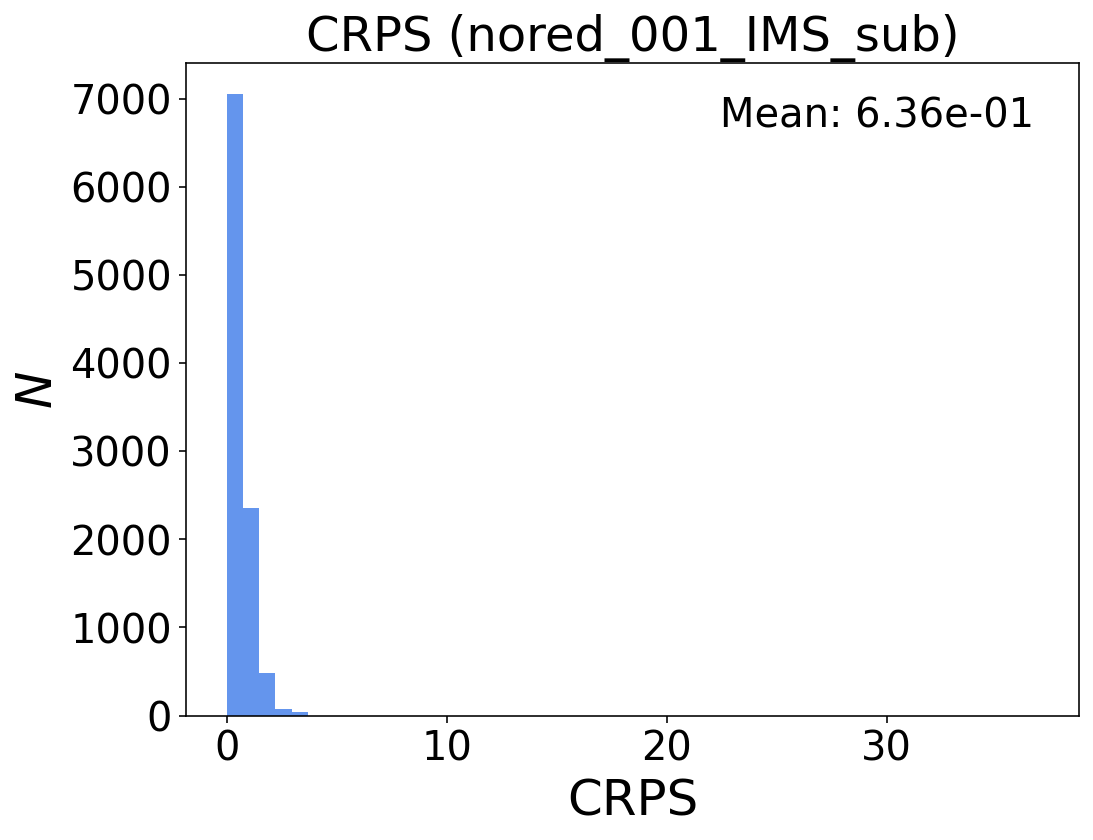

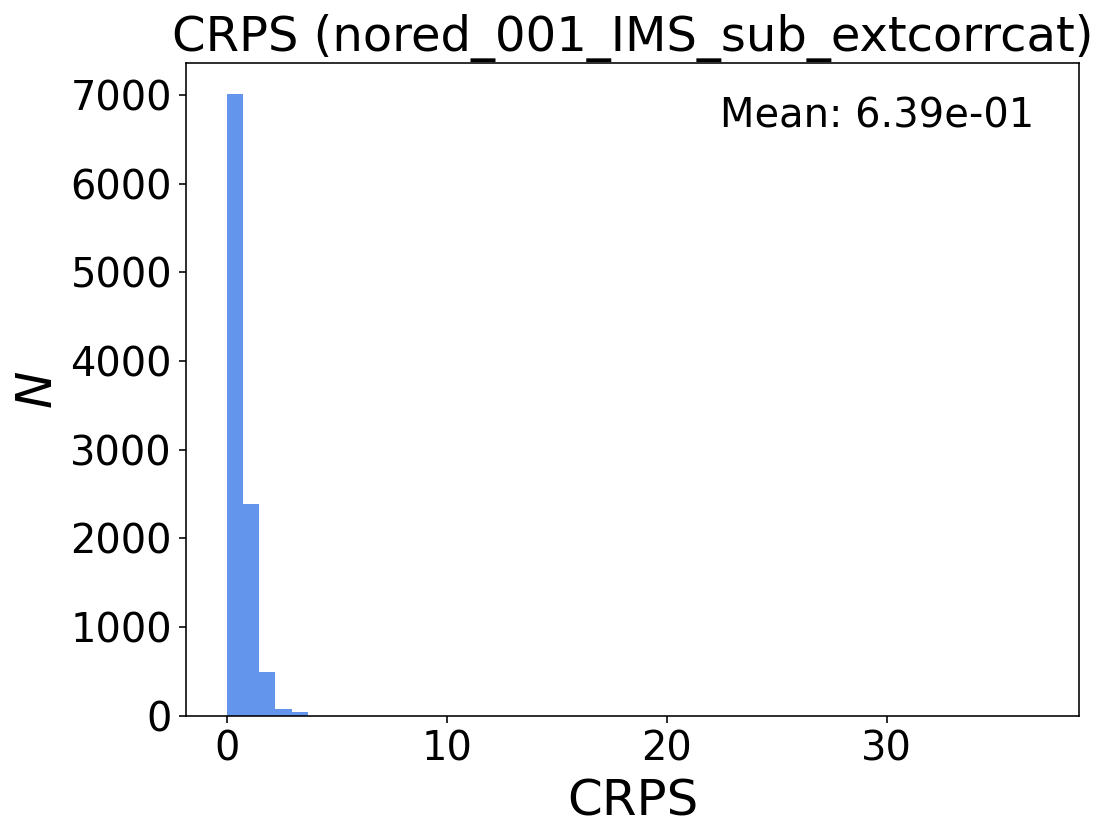

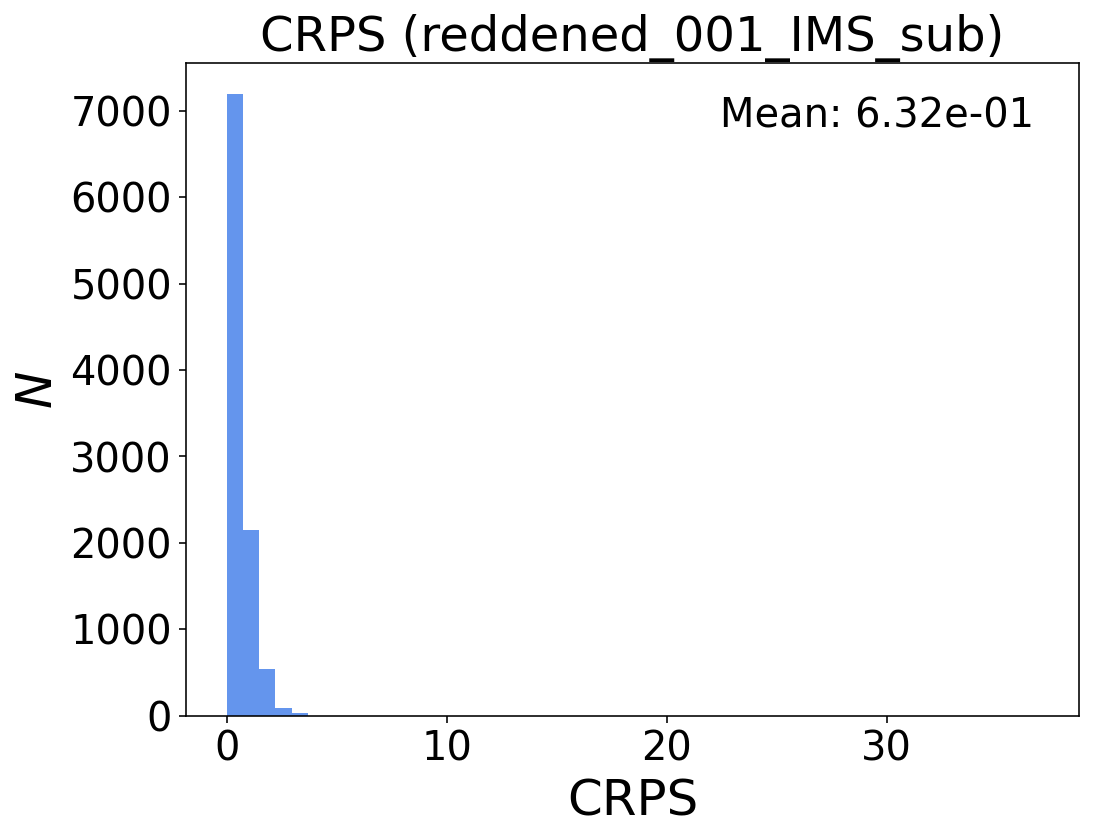

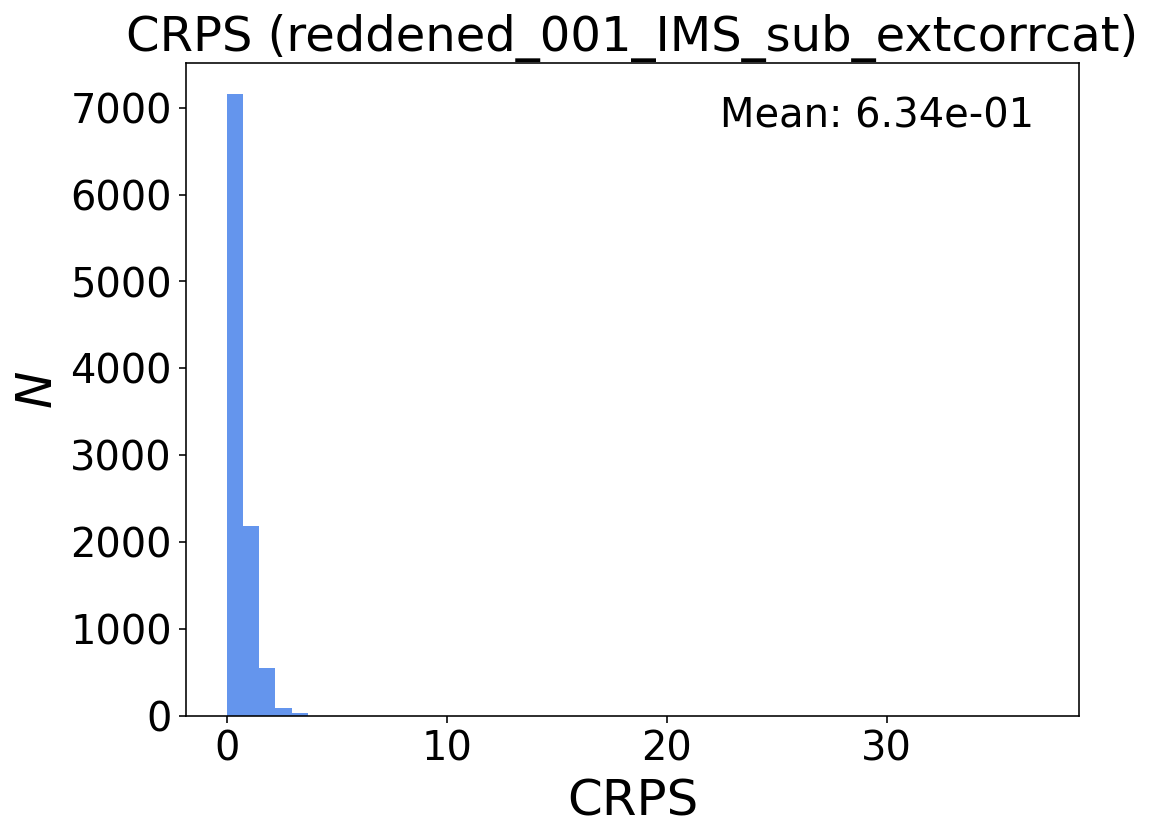

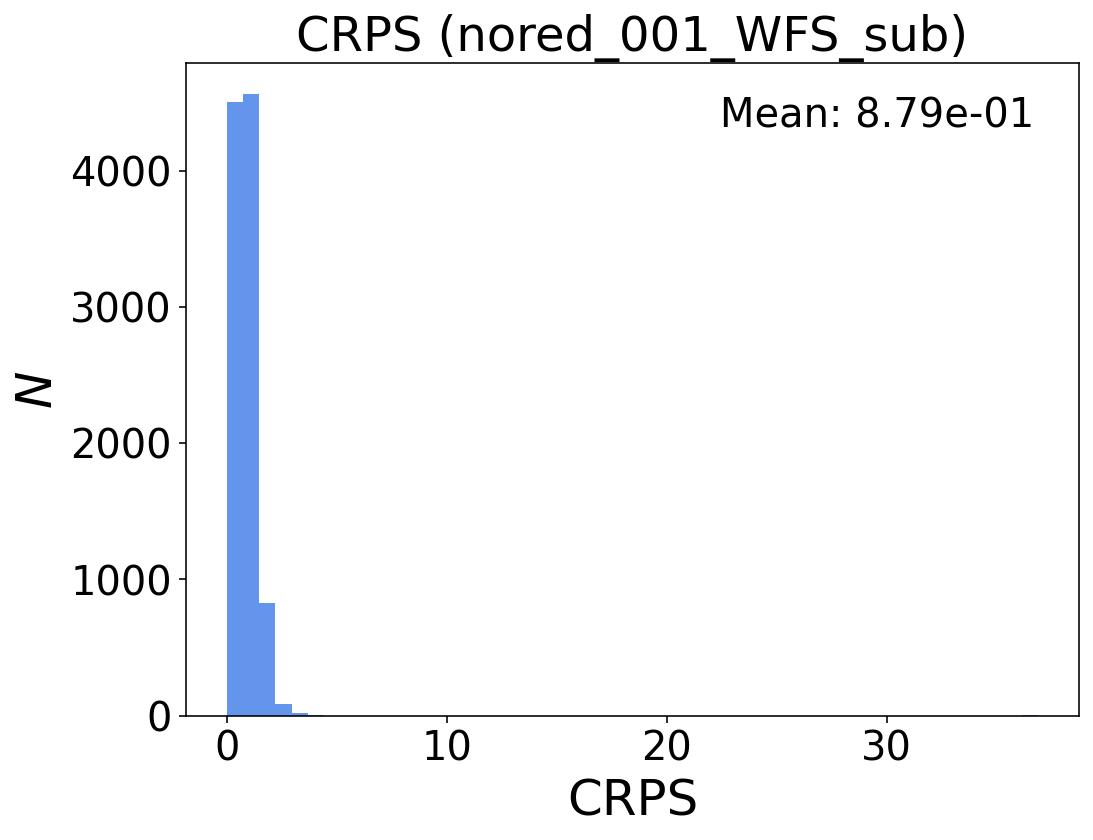

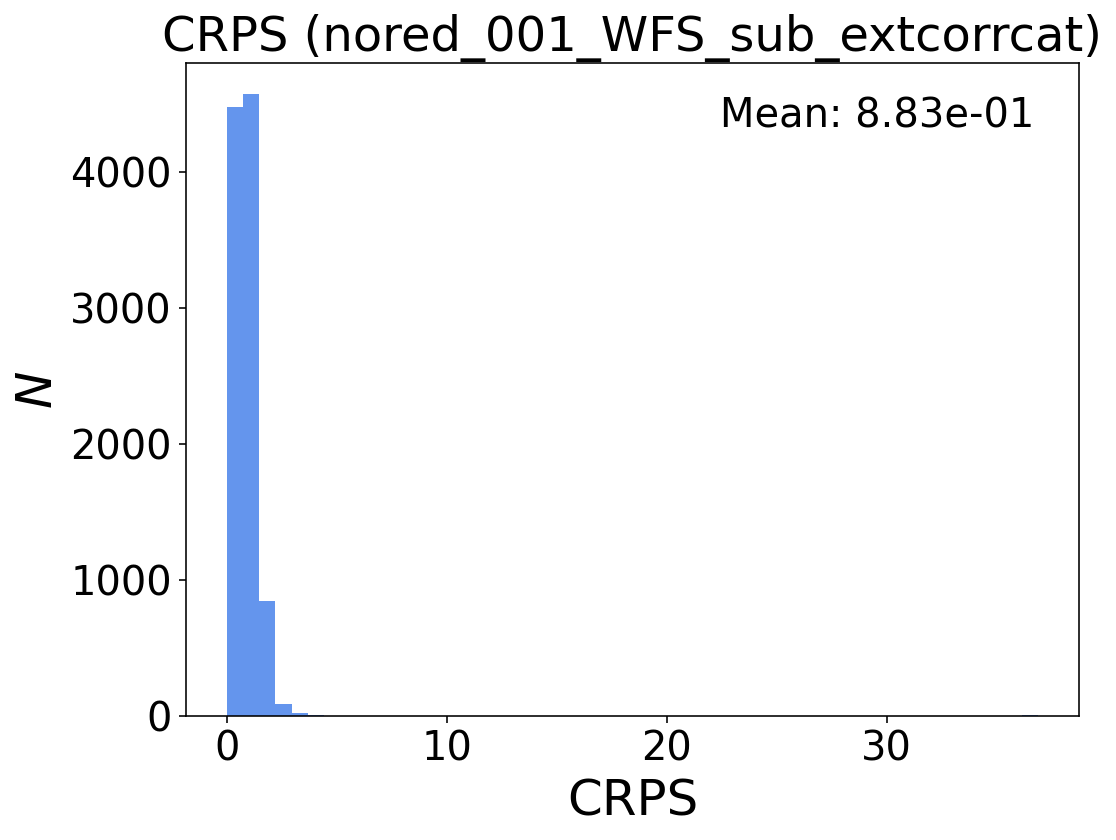

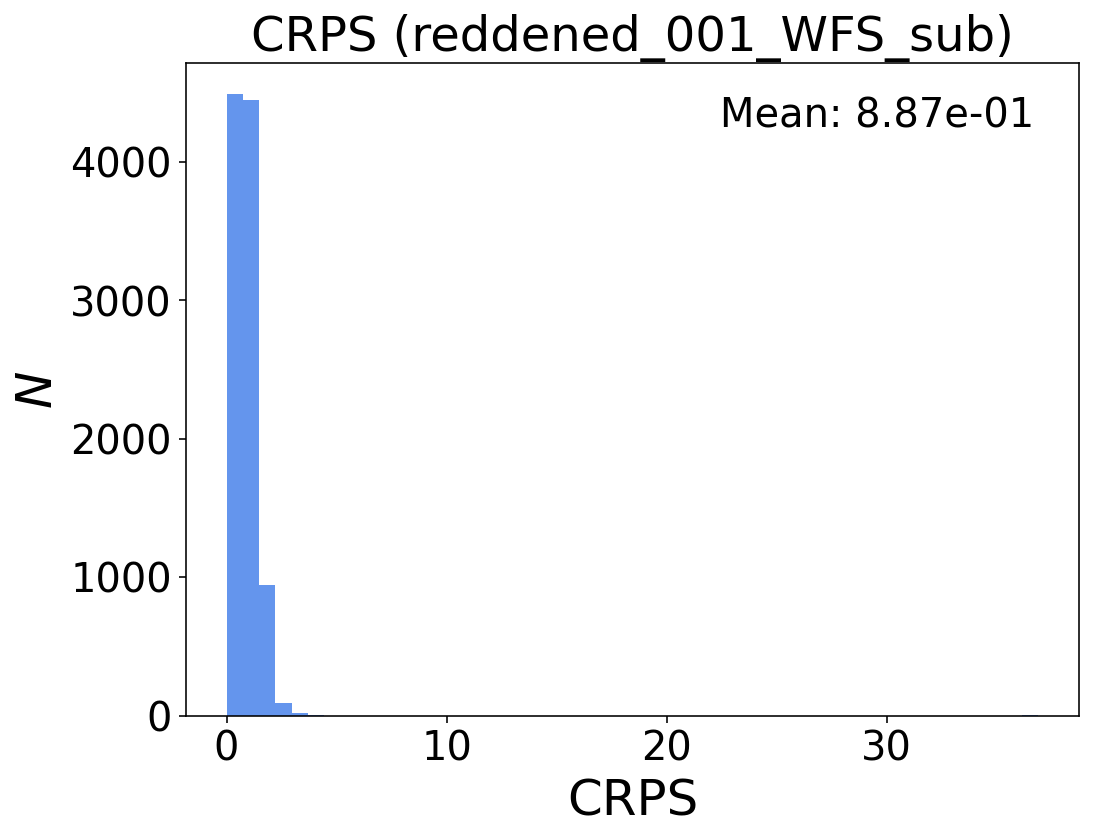

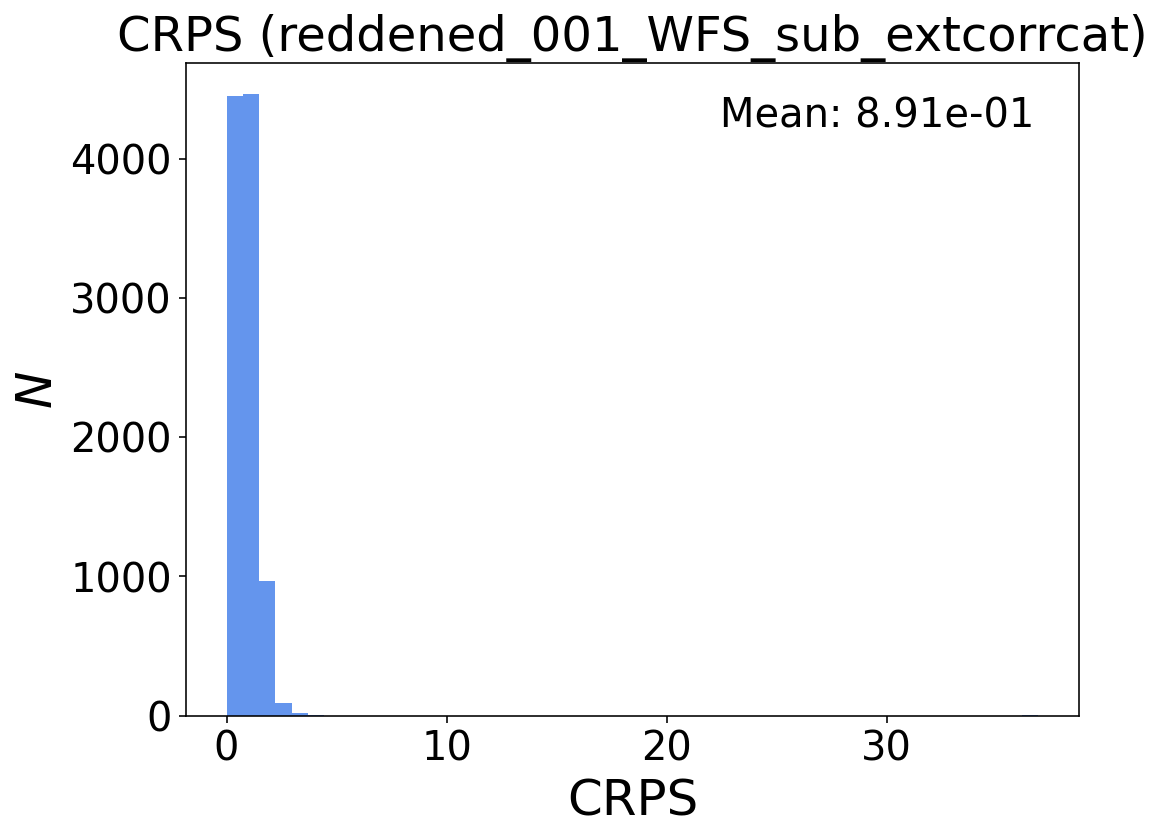

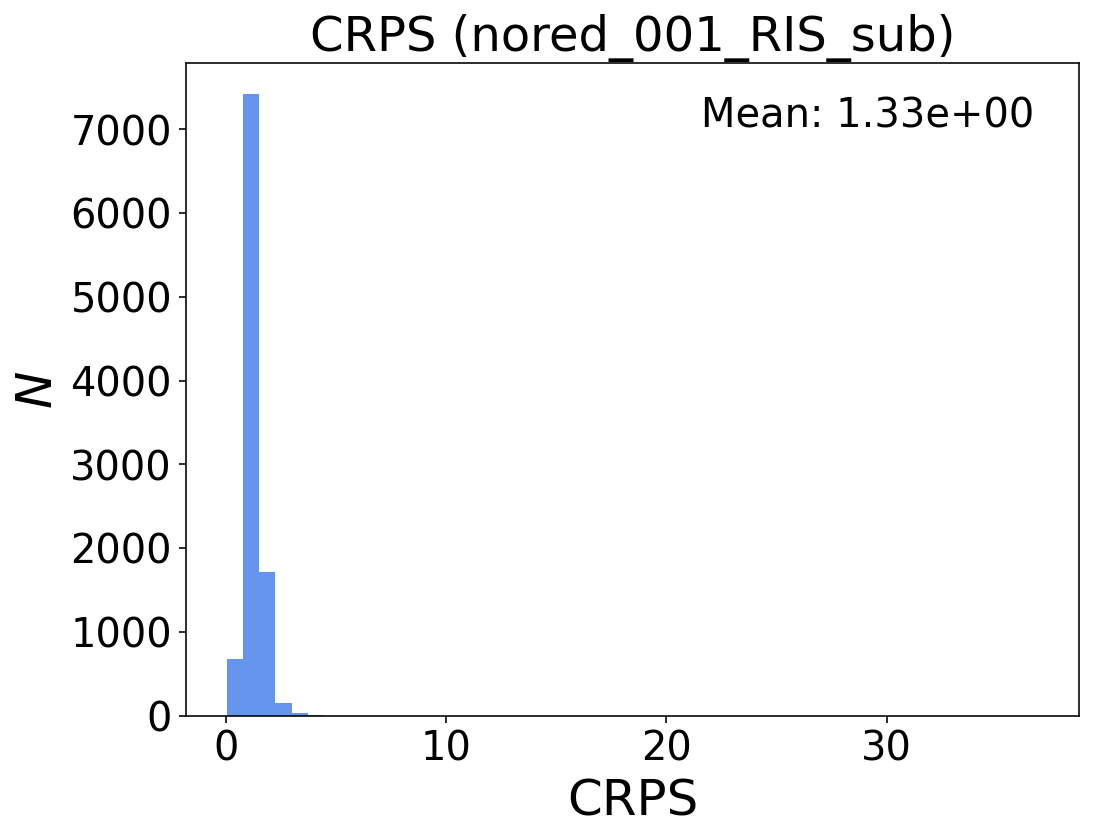

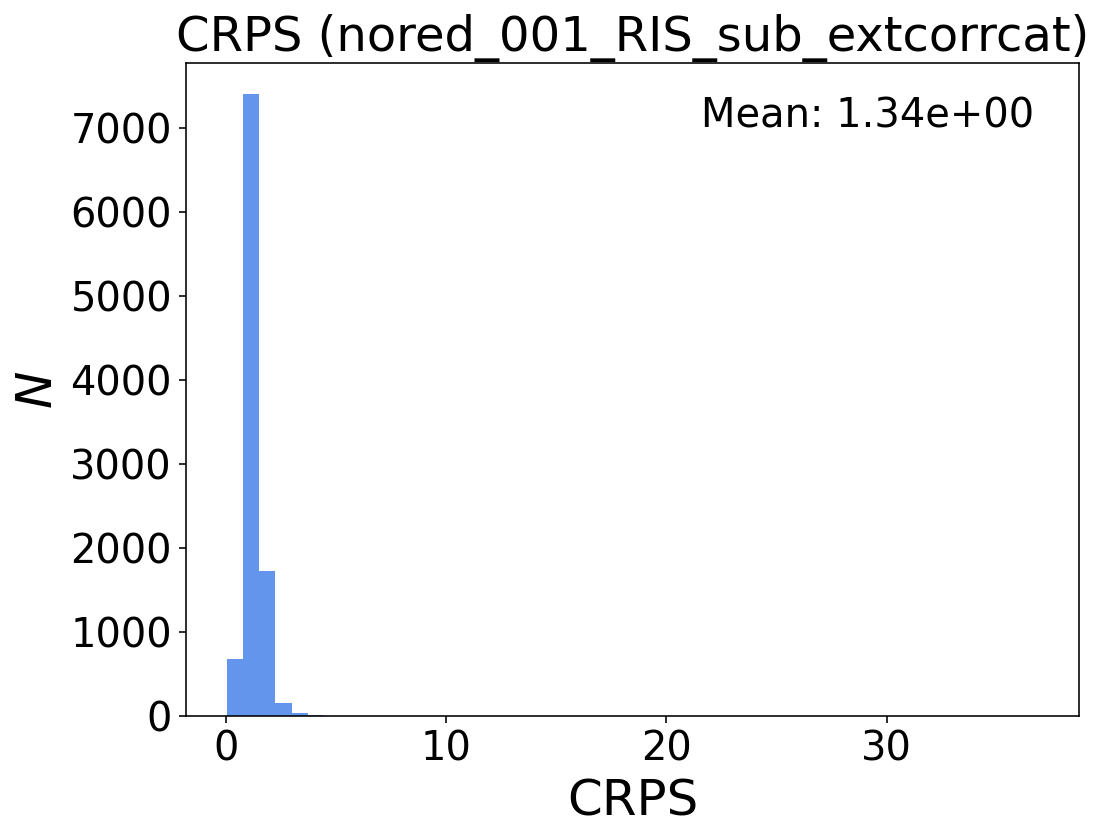

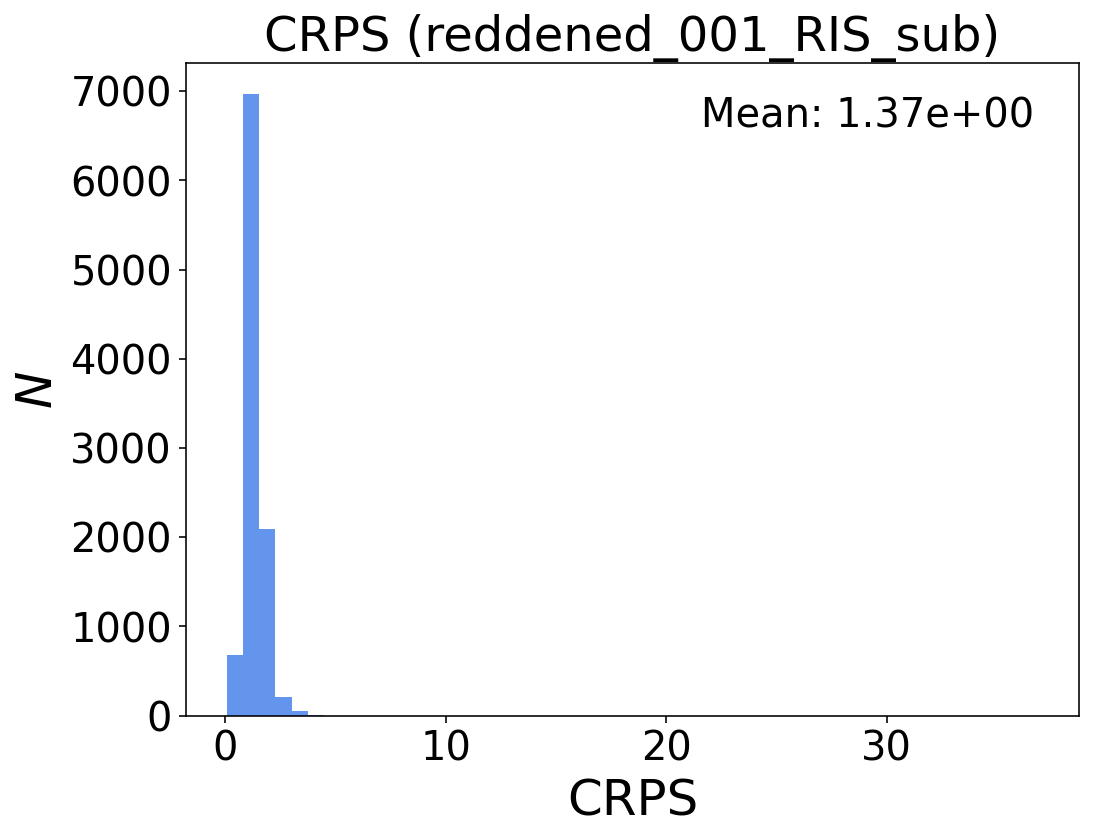

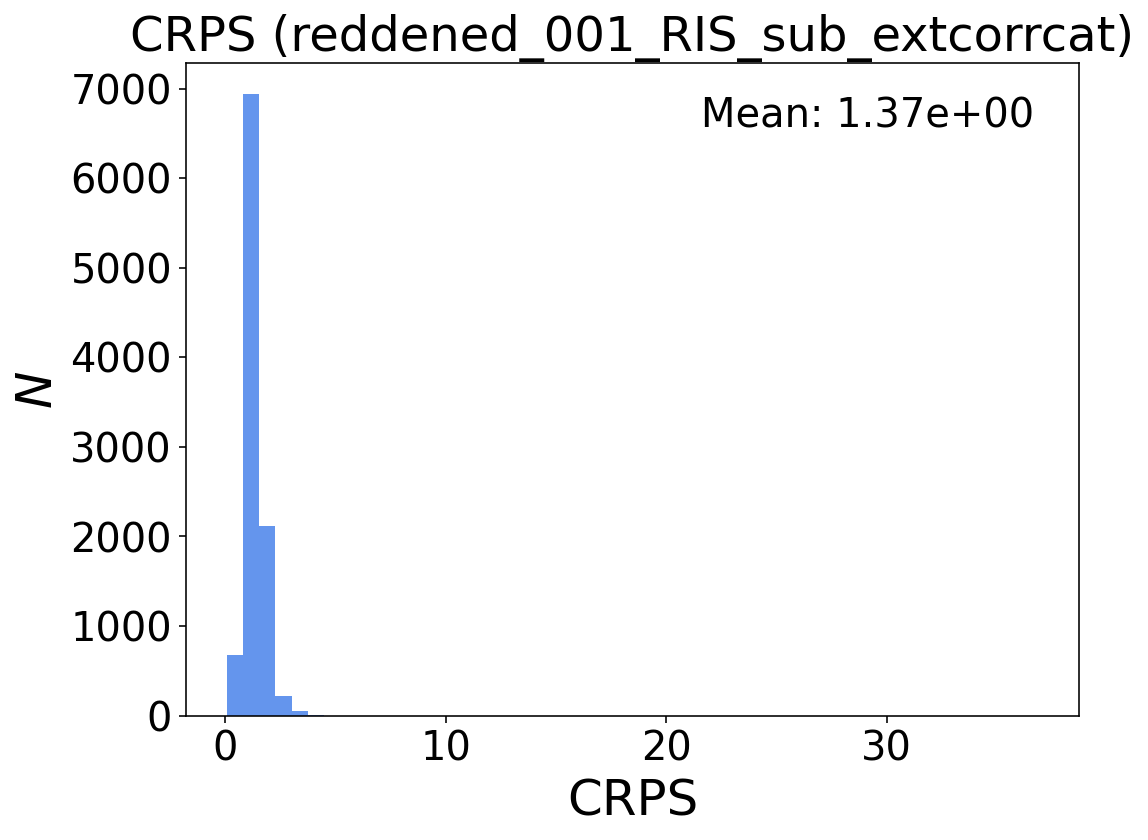

In [56]:
catalog = "_sub"
zstep = "001"
for surv in ["IMS", "WFS", "RIS"]:
    for temp in ["nored", "reddened"]:
        for extc in ["", "_extcorrcat"]:
            base = Table.read(WD/f'output/output_{temp}_{zstep}_{surv}{catalog}{extc}/result.fits')
            figdir = WD/f'output/output_{temp}_{zstep}_{surv}{catalog}{extc}/figures'
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111)
            ax.hist(base["pit"], bins=30, histtype="stepfilled", lw=1, color="cornflowerblue")
            ax.set_xlabel("PIT")
            ax.set_ylabel(r"$N$")
            ax.set_title(f"PIT ({temp}_{zstep}_{surv}{catalog}{extc})")
            fig.savefig(figdir/"pit_hist.png")
            plt.close()
            
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111)
            ax.hist(base["crps"], bins=50, histtype="stepfilled", lw=1, color="cornflowerblue")
            ax.set_xlabel("CRPS")
            ax.set_ylabel(r"$N$")
            ax.set_title(f"CRPS ({temp}_{zstep}_{surv}{catalog}{extc})")
            ax.text(0.95, 0.95, f"Mean: {np.mean(base['crps']):.2e}", transform=ax.transAxes, ha="right", va="top")
            fig.savefig(figdir/"crps_hist.png")

In [59]:
catalog = "_sub"
zstep = "001"
template = "reddened"
survey = "RIS"
extc = "_prior"
for surv in ["IMS", "WFS", "RIS"]:
    scheme, base, figdir = get_basecat_scheme(
        survey=surv,
        template=template,
        zstep=zstep,
        catalog=catalog,
        extcorr=extc,
    )
    
    base = Table.read(WD/f'output/output_{temp}_{zstep}_{surv}{catalog}{extc}/result.fits')
    
    lnp = fits.getdata(WD/f'output/output_{temp}_{zstep}_{surv}{catalog}{extc}/lnp.fits')
    zgrid = zgrid_reddened if temp == "reddened" else zgrid_nored
    trdz = trdz_reddened if temp == "reddened" else trdz_nored
    pit = get_pit(base["z_spec"], zgrid, lnp, trdz)
    crps = get_crps(base["z_spec"], zgrid, lnp, trdz)
    base["pit"] = pit
    base["crps"] = crps
    base.write(WD/f'output/output_{temp}_{zstep}_{surv}{catalog}{extc}/result.fits', overwrite=True)
    
    figdir = WD/f'output/output_{temp}_{zstep}_{surv}{catalog}{extc}/figures'
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.hist(base["pit"], bins=30, histtype="stepfilled", lw=1, color="cornflowerblue")
    ax.set_xlabel("PIT")
    ax.set_ylabel(r"$N$")
    ax.set_title(f"PIT ({temp}_{zstep}_{surv}{catalog}{extc})")
    fig.savefig(figdir/"pit_hist.png")
    plt.close()
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.hist(base["crps"], bins=50, histtype="stepfilled", lw=1, color="cornflowerblue")
    ax.set_xlabel("CRPS")
    ax.set_ylabel(r"$N$")
    ax.set_title(f"CRPS ({temp}_{zstep}_{surv}{catalog}{extc})")
    ax.text(0.95, 0.95, f"Mean: {np.mean(base['crps']):.2e}", transform=ax.transAxes, ha="right", va="top")
    fig.savefig(figdir/"crps_hist.png")
    plt.close()
    
    base.rename_column('z_spec', 'z_true')
    get_result_figures(base, figdir, scheme)

Calculating CRPS: 100%|██████████| 10000/10000 [00:24<00:00, 404.84it/s]


Objects : 9978
Outliers: 5373




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 9


Objects : 21
Outliers: 9




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 13




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 13




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 27




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 27




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 520
Outliers: 44




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 520
Outliers: 44




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1272
Outliers: 249




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1272
Outliers: 249




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7867
Outliers: 5031




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7867
Outliers: 5031




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 2222
Outliers: 303




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 2222
Outliers: 303




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 938
Outliers: 105




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 938
Outliers: 105




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
Calculating CRPS: 100%|██████████| 10000/10000 [00:25<00:00, 398.45it/s]


Objects : 9871
Outliers: 6514




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 7


Objects : 21
Outliers: 7




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 15




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 15




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 22




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 209
Outliers: 22




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 520
Outliers: 71




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 520
Outliers: 71




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1271
Outliers: 526




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1271
Outliers: 526




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7761
Outliers: 5873




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7761
Outliers: 5873




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 753
Outliers: 84




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 753
Outliers: 84




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 251
Outliers: 42




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 251
Outliers: 42




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
Calculating CRPS: 100%|██████████| 10000/10000 [00:26<00:00, 378.02it/s]


Objects : 9484
Outliers: 7486




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 21
Outliers: 3


Objects : 21
Outliers: 3




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 12




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 89
Outliers: 12




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 208
Outliers: 52




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 208
Outliers: 52




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 513
Outliers: 248




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 513
Outliers: 248




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1223
Outliers: 838




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 1223
Outliers: 838




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7430
Outliers: 6333




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))


Objects : 7430
Outliers: 6333




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:80: RuntimeWarning: divide by zero encountered in divide
  sigz = (np.max([z_840 - z_phot, z_phot - z_160], axis=0) / (1 + z_phot))
/data1/hbahk/spherex-photoz/spherex-challenge/7ds_challenge/utils.py:389: RuntimeWarning: divide by zero encountered in divide
  np.max([base["z840"] - base["z_phot"], base["z_phot"] - base["z160"]], axis=0)


Objects : 99
Outliers: 27




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 99
Outliers: 27




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 4
Outliers: 1




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Objects : 4
Outliers: 1




/data1/hbahk/envs/main/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
